In [1]:
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

# Q1. Downloading the data

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "**Yellow** Taxi Trip Records".

Download the data for January and February 2023.

In [3]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet

--2025-05-18 07:48:42--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.160.201.5, 18.160.201.50, 18.160.201.131, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.160.201.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47673370 (45M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-01.parquet’

yellow_tripdata_202 100%[===================>]  45.46M   169MB/s    in 0.3s    

2025-05-18 07:48:43 (169 MB/s) - ‘yellow_tripdata_2023-01.parquet’ saved [47673370/47673370]



In [4]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet

--2025-05-18 07:49:15--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.160.201.50, 18.160.201.5, 18.160.201.131, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.160.201.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47748012 (46M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-02.parquet’

yellow_tripdata_202 100%[===================>]  45.54M   179MB/s    in 0.3s    

2025-05-18 07:49:16 (179 MB/s) - ‘yellow_tripdata_2023-02.parquet’ saved [47748012/47748012]



In [13]:
df_train = pd.read_parquet('yellow_tripdata_2023-01.parquet')
df_val = pd.read_parquet('yellow_tripdata_2023-02.parquet')

In [14]:
df_val.rename({'Airport_fee': 'airport_fee'}, axis = 1, inplace = True)

In [5]:
#df = pd.concat([df_01, df_02], axis = 0)
#assert df.shape[0] == df_01.shape[0] + df_02.shape[0]

In [6]:
df_train.shape

(3066766, 19)

Read the data for January. How many columns are there?

- 16
- 17
- 18
- **19**

# Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.


In [7]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [15]:
df_train['duration'] = df_train.tpep_dropoff_datetime - df_train.tpep_pickup_datetime
df_train.duration = df_train.duration.apply(lambda td: td.total_seconds() / 60)

In [10]:
df.loc[(df['tpep_pickup_datetime'] >= '2023-01-01') & (df['tpep_pickup_datetime'] < '2023-02-01'), 'duration'].std()

42.585591889677

In [10]:
df_train.duration.std()

42.594351241920904

What's the standard deviation of the trips duration in January?
- 32.59
- **42.59**
- 52.59
- 62.59

# Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

<Axes: >

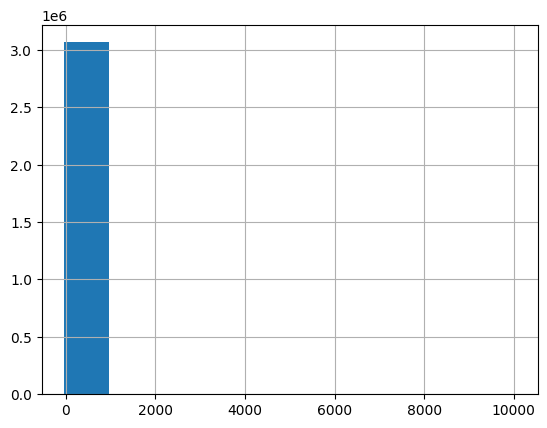

In [11]:
df_train.duration.hist()

In [16]:
df_train_full = df_train.copy()

In [17]:
df_train = df_train[(df_train.duration >= 1) & (df_train.duration <= 60)]

In [18]:
df_train.shape[0] / df_train_full.shape[0]

0.9812202822125979

What fraction of the records left after you dropped the outliers?

- 90%
- 92%
- 95%
- **98%**

# Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

In [19]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [20]:
categorical = ['PULocationID', 'DOLocationID']
#numerical = ['duration']

df_train[categorical] = df_train[categorical].astype(str)

In [21]:
train_dicts = df_train[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [22]:
X_train.shape

(3009173, 515)

#Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters, where duration is the response variable
- Calculate the RMSE of the model on the training data


In [23]:
target = 'duration'
y_train = df_train[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.649261932106969

What's the RMSE on train?

- 3.64
- **7.64**
- 11.64
- 16.64

# Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

In [25]:
df_val['duration'] = df_val.tpep_dropoff_datetime - df_val.tpep_pickup_datetime
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)

In [34]:
df_val_full = df_val.copy()
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]

In [38]:
df_val[categorical] = df_val[categorical].astype(str)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_val[target].values

In [39]:
root_mean_squared_error(y_val, lr.predict(X_val))

7.811818743246608

What's the RMSE on validation?

- 3.81
- **7.81**
- 11.81
- 16.81